In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib

import time
import cartopy.crs as ccrs
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
from tools.e5tools import e5_climatology
from orographicPrecipitation.observationsAndERA5.linear_precip_models_2D import *
xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

In [3]:
e5_pr_seasmean = 1e3*e5_climatology('128_228_tp',range(2001,2021))

46.64685034751892


In [4]:
era5d2_seasmean = e5_climatology('128_168_2d',range(2001,2021))
era5psfc_seasmean = e5_climatology('128_134_sp',range(2001,2021))
era5q2_seasmean = era5d2_seasmean**0*np.array(mpcalc.specific_humidity_from_dewpoint(np.array(era5d2_seasmean)*units.K,np.array(era5psfc_seasmean)*units.Pa))

37.772075176239014
28.524482488632202


In [5]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Vietnam",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"Papua New Guinea"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)

for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('ERA5_PR',e5_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Q_SFC',era5q2_seasmean)
    MR.set_2dvar('Z',orogm*landmask)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_uperp()
    MR.vars['VIWVE'] = xr.open_dataarray(MR.path+"e5.oper.an.vinteg.162_071_viwve.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).mean('time')
    MR.vars['VIWVN'] = xr.open_dataarray(MR.path+"e5.oper.an.vinteg.162_072_viwvn.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).mean('time')    
        

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [6]:
Ghats      .U0 = 10  ; Ghats      .V0 =  1  ; Ghats      .P0 = 3
Myanmar    .U0 =  8  ; Myanmar    .V0 =  8  ; Myanmar    .P0 = 7
Vietnam    .U0 = -7  ; Vietnam    .V0 = -5  ; Vietnam    .P0 = 4
Malaysia   .U0 = -7  ; Malaysia   .V0 = -5  ; Malaysia   .P0 = 10
Philippines.U0 = -8.5; Philippines.V0 = -3  ; Philippines.P0 = 5
Newbritain .U0 = -7.5; Newbritain .V0 =  5.5; Newbritain .P0 = 4


In [7]:
Ghats      .angle = 80 ; Ghats      .width = 0.2
Myanmar    .angle = 50 ; Myanmar    .width = 0.23
Vietnam    .angle = 240; Vietnam    .width = 0.1
Malaysia   .angle = 240; Malaysia   .width = 0.1
Philippines.angle = 250; Philippines.width = 0.25
Newbritain .angle = 310; Newbritain .width = 0.1

In [8]:
%%time 
for MR in MRs:
    MR.vars['LINEAR_PR']  = p_lineartheory_region(MR, topo='ETOPO', pad='big', N=0.01                 )
    MR.vars['LINEAR_PR_NOLQ']  = p_lineartheory_region(MR, topo='ETOPO', pad='big', N=0.01, switch=1e-4)
    MR.vars['SMITH_PR']   = p_smiththeory_region (MR, topo='ETOPO', pad='big', N=0.01, gamma_m=4.32e-3)
    MR.vars['UPSLOPE_PR'] = p_upslope_region(MR,topo='ERA5', version='IVT')

CPU times: user 5min 19s, sys: 1min 44s, total: 7min 3s
Wall time: 7min 2s


In [9]:
for MR in MRs:
    MR.set_daily_Bl_vars('semi')
    MR.set_daily_imerg()

In [25]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    #ax.set_xticks(lons)
    #ax.set_xticklabels(lons)
    #ax.set_yticks(lats)
    #ax.set_yticklabels(lats)
    
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    if ftz:
        ax.tick_params(axis='both', which='major', labelsize=ftz)
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
        

def rot_slice(var,angle,width):
    rvar = rotate_var(var.transpose('latitude','longitude'),angle)
    n,m = rvar.shape
    bounds = int(m*(0.5-width)), int(m*(0.5+width))
    return rvar.isel(y=slice(*bounds)).mean('y')
from scipy.ndimage import gaussian_filter
def filtr(da):
    sigma=4
    return da**0*gaussian_filter(da,sigma)

from scipy.optimize import curve_fit
def fit(pred,dep,model='linear',return_func = False):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    if return_func:
        print(popt)
        return predrange,fitrange,rsq,lambda x: func(x,*popt)
    else:
        return predrange,fitrange,rsq

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=10):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.array([select_bootstrap_sample(data).mean() for _ in range(nsamples)])
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means

# Testing linear theories

In [30]:
def topographic_profile_2D(a=100e3,A=1000):
    xx=np.arange(-3000e3,3000e3,10e3)
    yy=np.arange(-2000e3,2000e3,10e3)
    hxy = A*np.exp(-(xx[:,None]**2+yy[None,:]**2/10)/2/(a/2)**2)
    return xx,yy,hxy

3.070336391437309
CPU times: user 136 ms, sys: 93 µs, total: 136 ms
Wall time: 135 ms
CPU times: user 149 ms, sys: 631 µs, total: 150 ms
Wall time: 149 ms


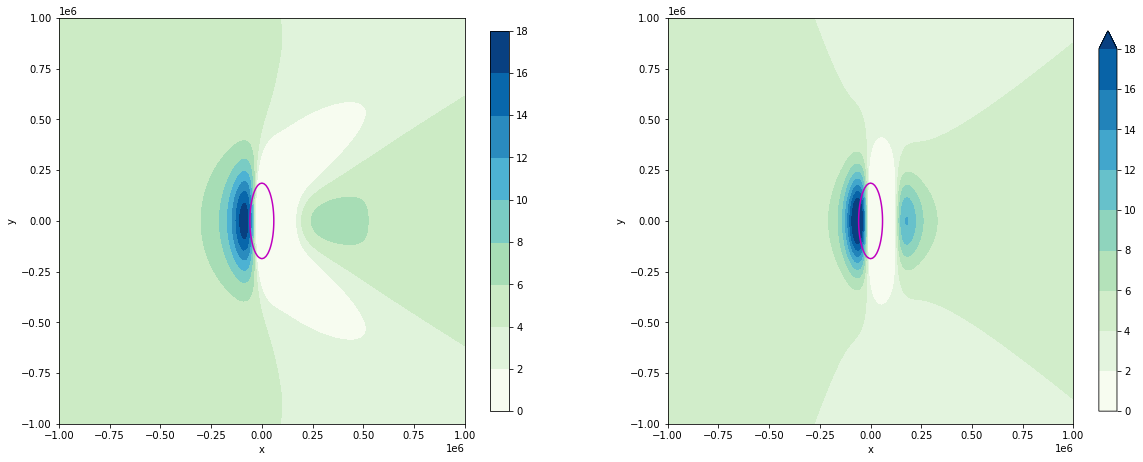

In [31]:
xx,yy,hxy = topographic_profile_2D(); hxy_xr = xr.DataArray(hxy,coords={'x':xx,'y':yy},dims=['x','y'])
%time P_us = linear_precip_theory_2D(xx,yy,hxy,10,0,0.01,tauT=7.5,tauq=27.5)
%time P_smith = smith_theory_2D(xx,yy,hxy,10,0,0.01,4.32e-3)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
P_us.plot.contourf(ax=ax1,x='x',levels=np.arange(0.,20.,2.),cmap=plt.cm.GnBu,cbar_kwargs={'shrink':0.7})
P_smith.plot.contourf(ax=ax2,x='x',levels=np.arange(0.,20.,2.),cmap=plt.cm.GnBu,cbar_kwargs={'shrink':0.7})

for ax in (ax1,ax2):
    hxy_xr.plot.contour(ax=ax,x='x',levels=[500],colors=['m'])
    ax.set_aspect('equal')
    ax.set_xlim(-1000e3,1000e3)
    ax.set_ylim(-1000e3,1000e3)

# Applying linear theories to real data cases

## Estimating lapse rates

In [33]:
# Stability
Newbritain.set_3dvar('PHI',"128_129_z")
sample_geopotential = Newbritain.vars['PHI'].mean(['latitude','longitude'])/9.81
dzdp = sample_geopotential.differentiate('level')

for MR in MRs:
    t_upstream_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_130_t.ll025sc.2001-2020.{}.{}.upstreammean.nc".format(MR._monthstr,MR.name))
    dTdp = t_upstream_daily.differentiate('level')
    dTdz = dTdp/dzdp
    print(MR.name, "%.4f"%(1004*dTdz.sel(level=slice(200,900)).mean()))


ghats -5.9707
myanmar -6.0379
vietnam -5.8518
malaysia -6.0329
philippines -5.9494
newbritain -5.9005


In [34]:
for MR in MRs:
    q_upstream_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_133_q.ll025sc.2001-2020.{}.{}.upstreammean.nc".format(MR._monthstr,MR.name))
    dqdp = q_upstream_daily.differentiate('level')
    dqdz = dqdp/dzdp
    print(MR.name, "%.4f"%(2.5e6*dqdz.sel(level=slice(700,900)).mean()))


ghats -8.4319
myanmar -8.1084
vietnam -8.0530
malaysia -7.1564
philippines -8.9743
newbritain -7.6447


## Ghats maps

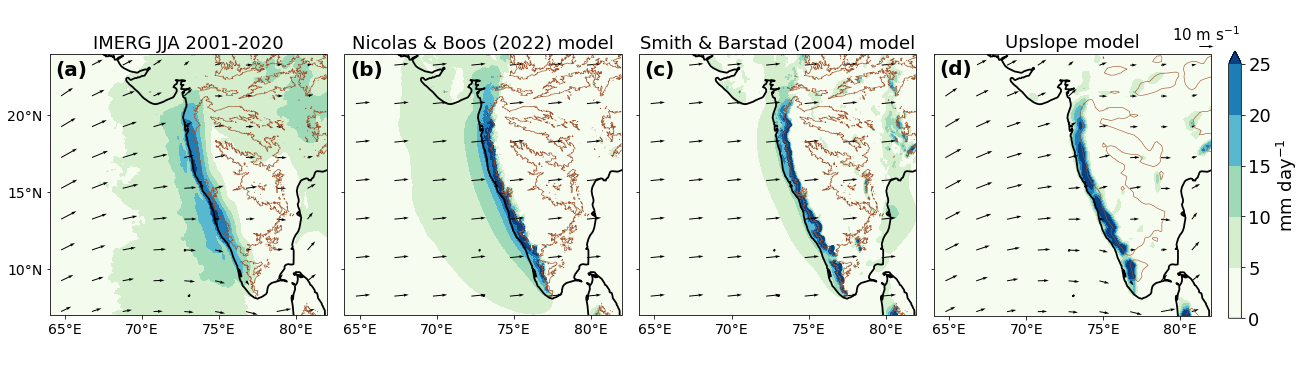

In [27]:
matplotlib.rcParams.update({'font.size': 18})
MR=Ghats
fig = plt.figure(figsize=(18,5))
spec = gridspec.GridSpec(ncols=5, nrows=1, width_ratios= [1,1,1,1,0.05],figure=fig)
titles = ("IMERG JJA 2001-2020","Nicolas & Boos (2022) model","Smith & Barstad (2004) model","Upslope model")
letters = ['a','b','c','d']
for i,pr in enumerate((MR.vars['GPM_PR'],MR.vars['LINEAR_PR'],MR.vars['SMITH_PR'],0.25*MR.vars['UPSLOPE_PR'])):
    pr[0,0]=26.
    ax = fig.add_subplot(spec[i],projection= ccrs.PlateCarree())
    
    ### PRECIP ###
    c = pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    ### QUIVERS ###
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8; m=n
    ibeg=3;iend=-1
    sc=0.7;w=1
    if i==0 or i==3:
        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')
    else:
        n = int(n*1.25)
        m=n    
        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')

    ### COSMETICS ###
    ax.coastlines(linewidth=1.8)
    if i<3:
        MR.vars['Z_HR'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
    else:
        MR.vars['Z'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
    add_latlon(ax,MR.box,ftz=14)
    if i>0:
        ax.set_yticklabels("")
    ax.set_title(titles[i],fontsize=18)
    ax.text(0.02, 0.92,'(%s)'%letters[i], transform=ax.transAxes,color='k',weight='bold',fontsize=20,backgroundcolor='#F7FCF0')

ax.quiverkey(Q, 0.98,1.03, 10, label=r'10 m s$^{-1}$', labelpos='N',
               coordinates='axes',color='k',labelsep=0.03,fontproperties={'size':15})
  
# Colorbar
axcbar = fig.add_subplot(spec[-1])
axcbar.axis('off')
fig.colorbar(c,ax=axcbar,fraction=1,shrink=0.75,orientation='vertical',label=r'mm day$^{-1}$')   
fig.tight_layout(pad=0.1,w_pad=0.7)

fig.savefig('figs/ghatsmaps.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/ghatsmaps.png',dpi=70,bbox_inches='tight')



## For reference: Maps for other regions

In [ ]:
for MR in MRs:
    print(MR.name)
    u = spatial_mean(MR.vars['VAR_100U'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    v = spatial_mean(MR.vars['VAR_100V'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    pr = spatial_mean(MR.vars['GPM_PR'],box=MR.box_upstream,mask = None)
    print("U=%i,V=%i,Pr=%.1f"%(u,v,pr))

ghats
U=9,V=0,Pr=2.2
myanmar
U=6,V=6,Pr=9.6
vietnam
U=-3,V=-3,Pr=6.1
malaysia
U=-3,V=-2,Pr=5.9
philippines
U=-6,V=-4,Pr=5.3
newbritain
U=-5,V=6,Pr=7.9


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


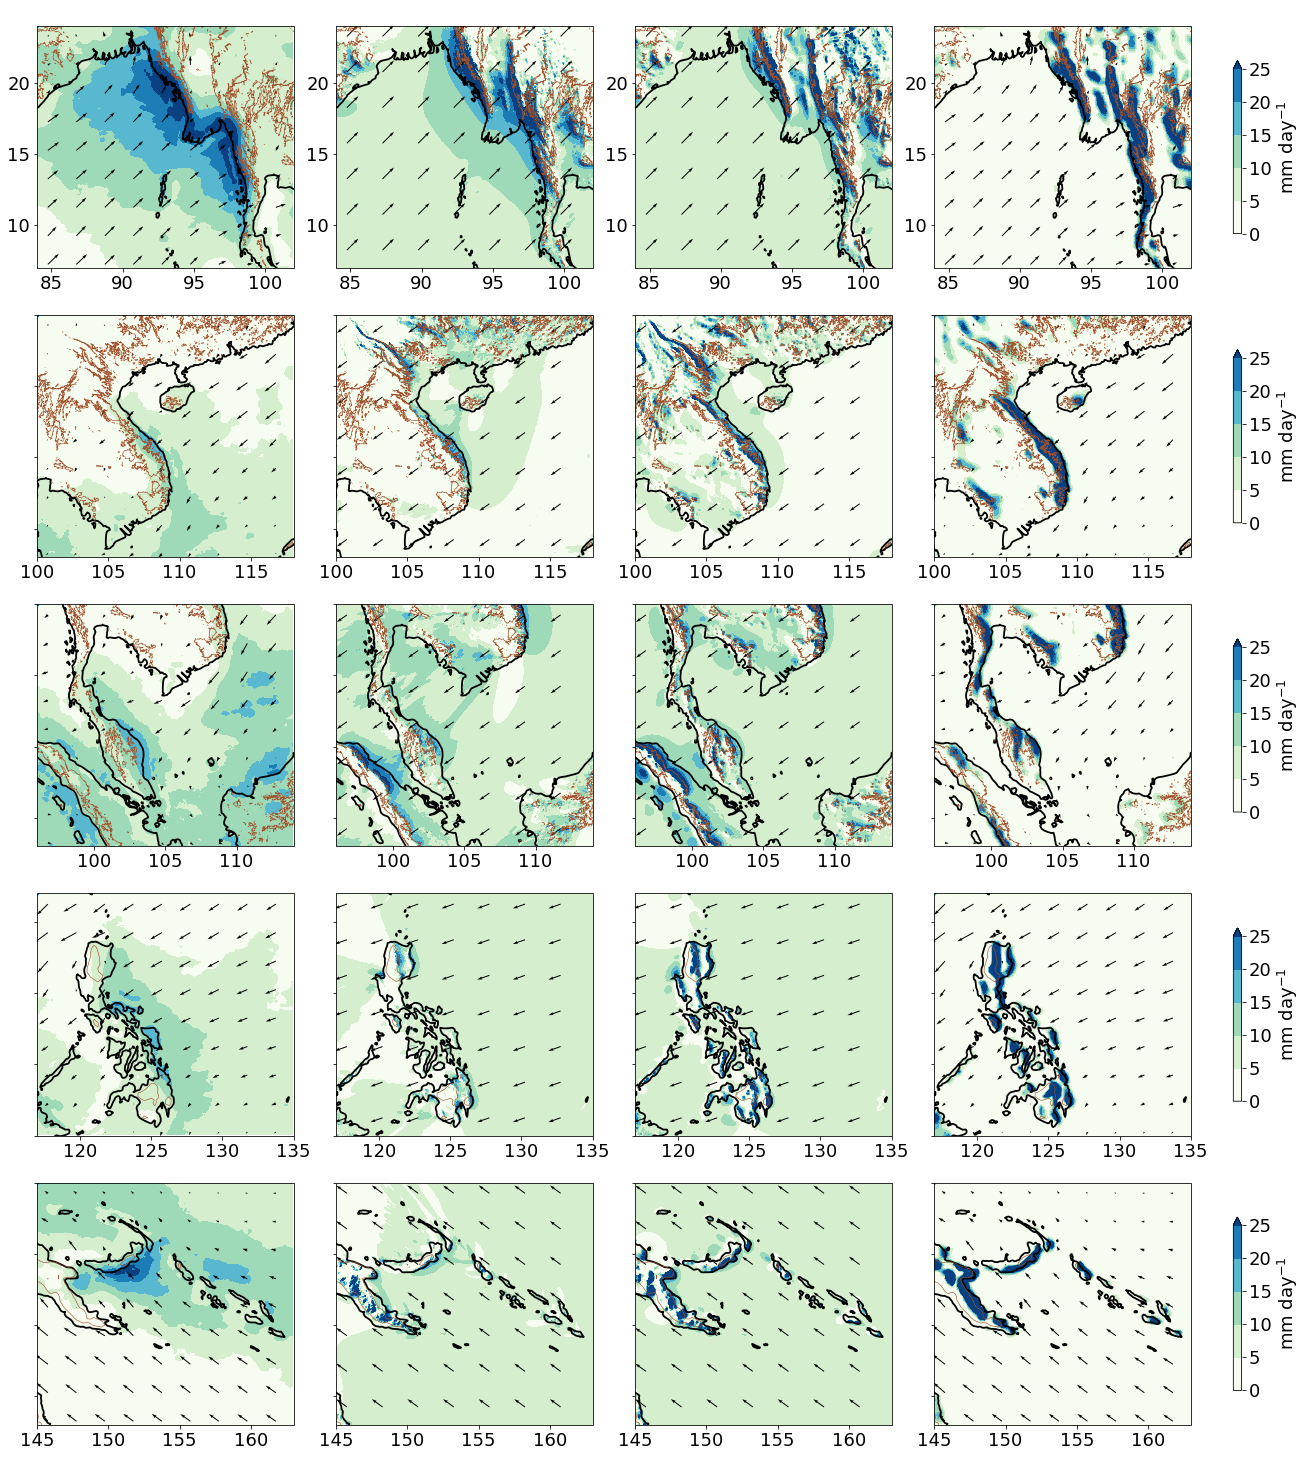

In [63]:
fig = plt.figure(figsize=(18,4*5))
spec = gridspec.GridSpec(ncols=5, nrows=5, width_ratios= [1,1,1,1,0.05],figure=fig)
for i,MR in enumerate(MRs[1:]):
    for j,pr in enumerate((MR.vars['GPM_PR'],MR.vars['LINEAR_PR'],MR.vars['SMITH_PR'],MR.vars['UPSLOPE_PR'])):
        pr[0,0]=26.
        ax = fig.add_subplot(spec[i,j],projection= ccrs.PlateCarree())
        
        c = pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
        
        ### QUIVERS ###
        u=MR.vars['VAR_100U']
        v=MR.vars['VAR_100V']
        X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
        Y = u.longitude.expand_dims({"latitude":u.latitude})
        n=len(u.latitude)//8; m=n
        ibeg=3;iend=-1
        sc=0.7;w=1
        if j==0 or j==3:
            Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')
        else:
            n = int(n*1.25)
            m=n    
            Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')
    
        ### COSMETICS ###
        ax.coastlines(linewidth=1.8)
        if i<3:
            MR.vars['Z_HR'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
        else:
            MR.vars['Z'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
        add_latlon(ax,MR.box)
        if i>0:
            ax.set_yticklabels("")
        ax.set_title("")

    # Colorbar
    axcbar = fig.add_subplot(spec[i,-1])
    axcbar.axis('off')
    fig.colorbar(c,ax=axcbar,fraction=1,shrink=0.62,orientation='vertical',label=r'mm day$^{-1}$')   
    fig.tight_layout(pad=0.1,w_pad=0.7)


## Precip from BL

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[20.92564248  3.92853961]


(0.0, 35.0)

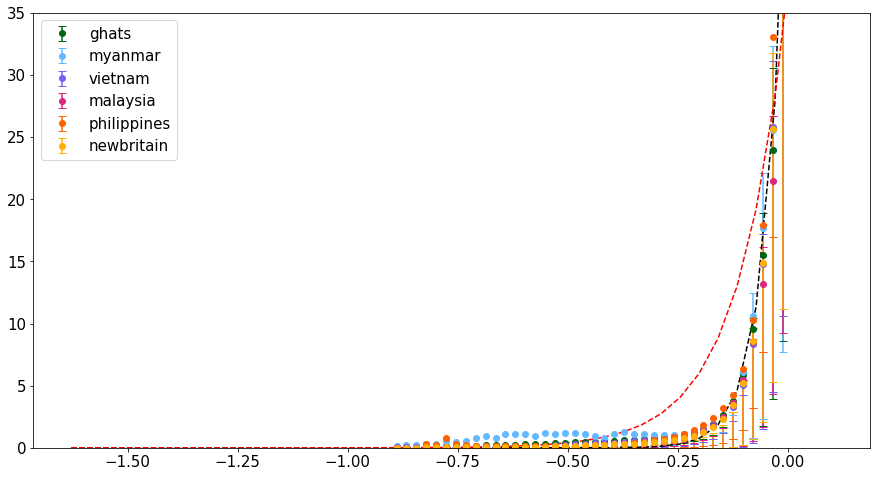

In [31]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
colors = ['#006511','#64B9FF','#785EF0','#DC267F','#FE6100','#FFB000']

allBLs = np.zeros(67*71*6*1840)*np.nan
allprs = np.zeros(67*71*6*1840)*np.nan
for i,MR in enumerate(MRs):
    BL = MR.vars['BLSEMI_DAILY']
    pr=MR.vars['GPM_PR_DAILY'].transpose('time','latitude','longitude').interp_like(BL)
    idxs = (~np.isnan(pr))
    bins = np.linspace(-0.9,0.,41)
    BL = np.array(BL)[idxs].reshape(-1)
    pr = np.array(pr)[idxs].reshape(-1)
    centers,means,_,q02,q98 = get_binned(BL,pr,bins,itq=True)
    ax.errorbar(centers,means,yerr=[(means-q02),(q98-means)],fmt='o',color=colors[i],ecolor=colors[i],capsize=4,label=MR.name)
    allBLs[67*71*1840*i:67*71*1840*i+len(BL)] = BL
    allprs[67*71*1840*i:67*71*1840*i+len(BL)] = pr
idxs = (~np.isnan(allBLs))
allBLs=allBLs[idxs];allprs=allprs[idxs];
x,y,rsq,BLPRFIT = fit(allBLs,allprs,model='exponential',return_func=True)
ax.plot(x,y,'--k')

a=9; b=0.4; BLPRFIT_PERSO = lambda x: np.exp(a*(x+b))
ax.plot(x,BLPRFIT_PERSO(x),'--r')
        
ax.legend()
ax.set_ylim(0,35)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/q/qnicolas

[8.17381721 3.24420136]
[8.71972226 3.3712775 ]


(0.0, 35.0)

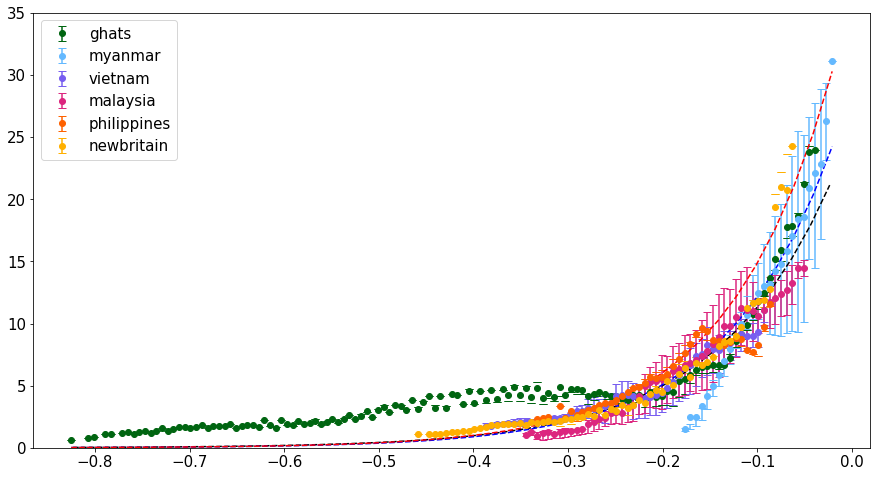

In [11]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
colors = ['#006511','#64B9FF','#785EF0','#DC267F','#FE6100','#FFB000']

allBLs = np.zeros(67*71*6)
allprs = np.zeros(67*71*6)
allcenters = np.array([])
allmeans = np.array([])
for i,MR in enumerate(MRs):
    BL = (MR.vars['BLSEMI_DAILY'].mean('time'))
    pr=MR.vars['GPM_PR'].interp_like(BL)
    bins = np.linspace(-0.9,0,151)
    centers,means,_,q02,q98 = get_binned(BL[1:-1,1:-1],pr[1:-1,1:-1],bins,itq=True)
    ax.errorbar(centers,means,yerr=[(means-q02),(q98-means)],fmt='o',color=colors[i],ecolor=colors[i],capsize=4,label=MR.name)
    allBLs[67*71*i:67*71*(i+1)] = np.array(BL[1:-1,1:-1]).reshape(-1)
    allprs[67*71*i:67*71*(i+1)] = np.array(pr[1:-1,1:-1]).reshape(-1)
    allcenters = np.concatenate((allcenters,centers))
    allmeans = np.concatenate((allmeans,means))
idxs = (~np.isnan(allBLs))
allBLs=allBLs[idxs];allprs=allprs[idxs];
x,y,rsq,BLPRFIT = fit(allBLs,allprs,model='exponential',return_func=True)
ax.plot(x,y,'--k')

idxs=~np.isnan(allmeans)
x,y,rsq,BLPRFIT2 = fit(allcenters[idxs],allmeans[idxs],model='exponential',return_func=True)
ax.plot(x,y,'--b')

a=9; b=0.4; BLPRFIT_PERSO = lambda x: np.exp(a*(x+b))
ax.plot(x,BLPRFIT_PERSO(x),'--r')
        
ax.legend()
ax.set_ylim(0,35)

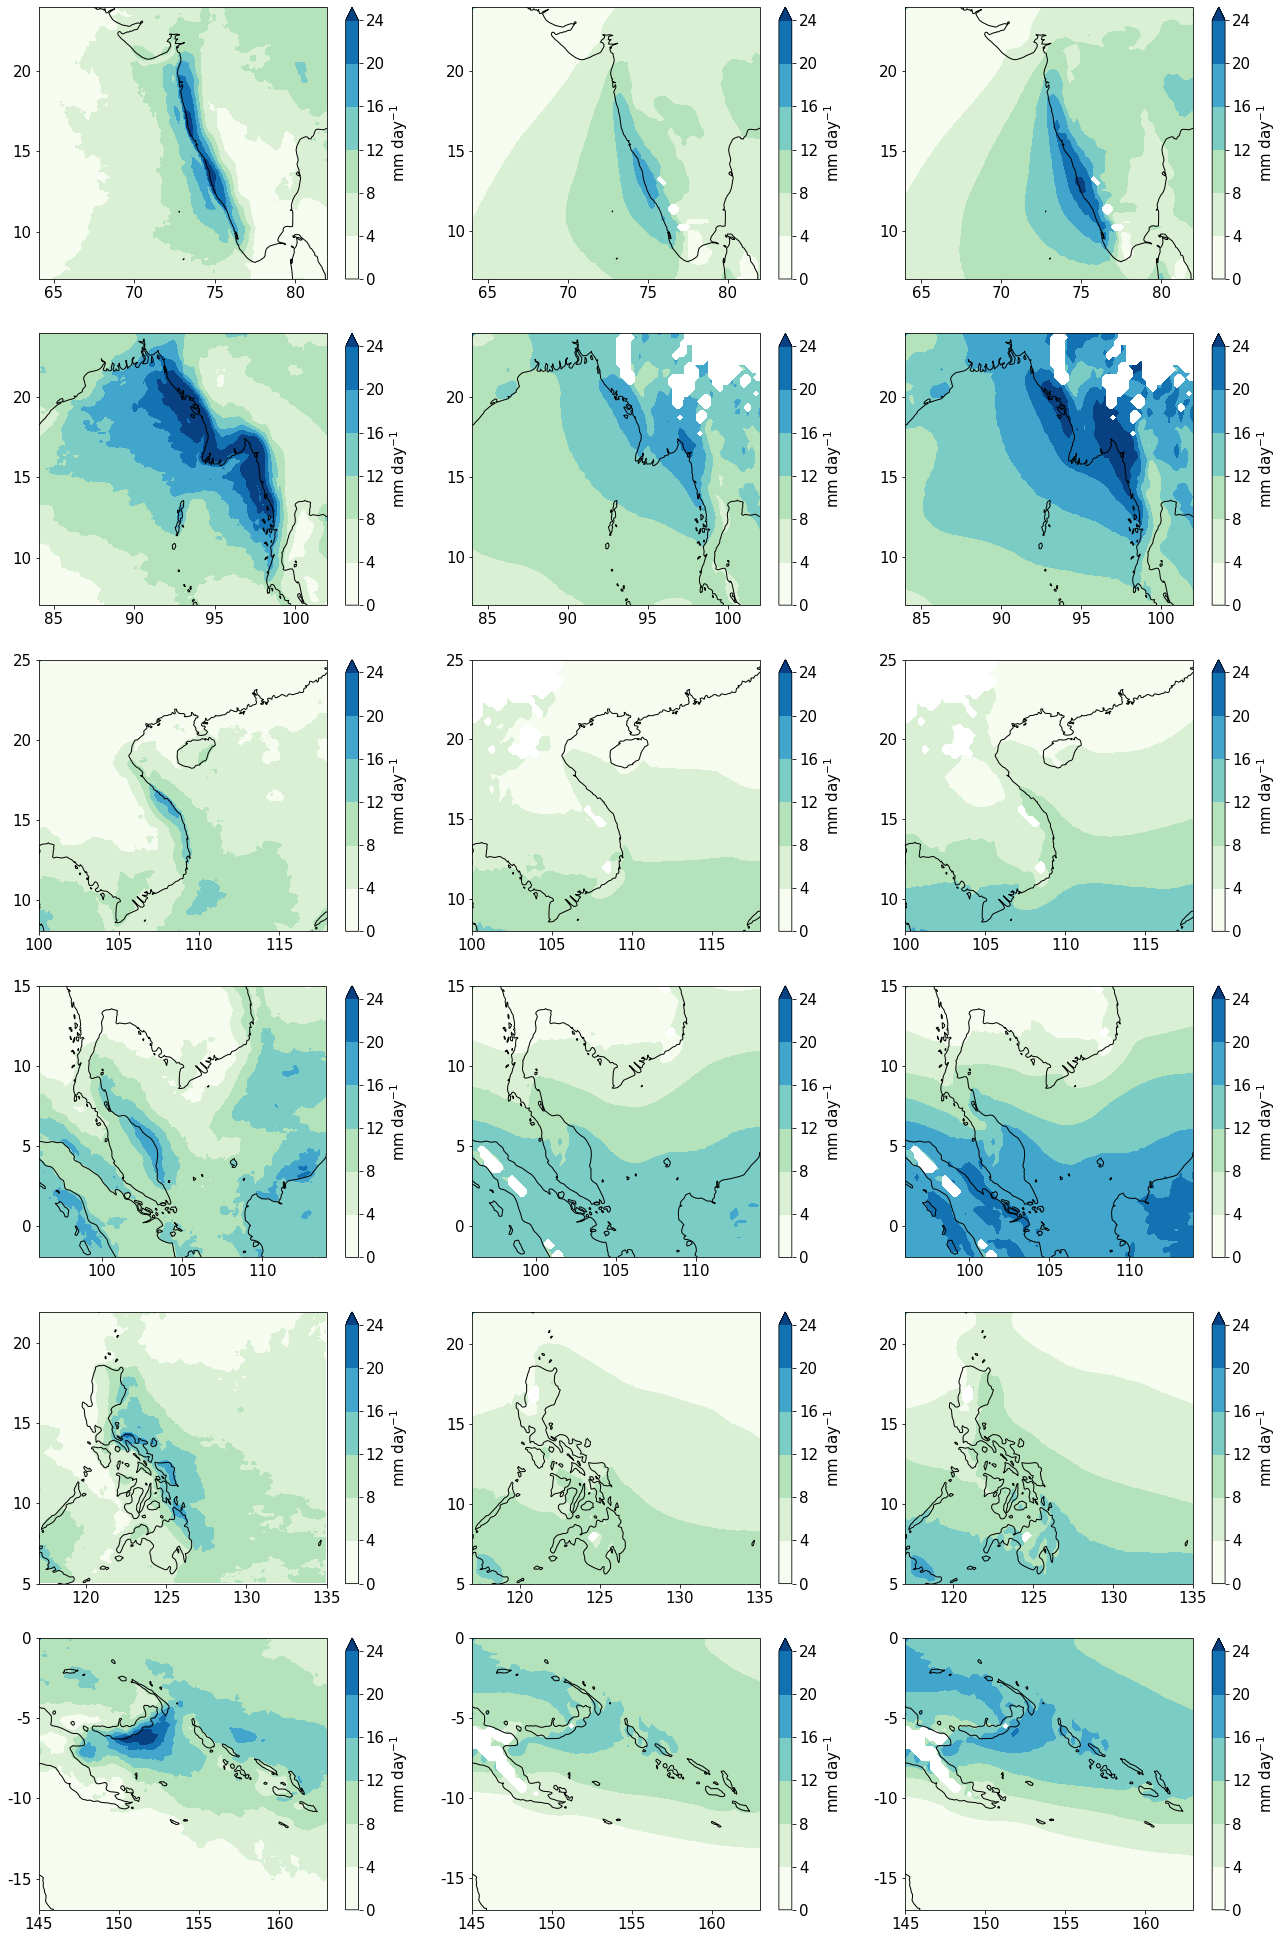

In [106]:
fig,axss = plt.subplots(6,3,figsize=(22,35),subplot_kw={'projection': ccrs.PlateCarree()})
for i,MR in enumerate(MRs):
    axs = axss[i]
    
    ax=axs[0]
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,4.),cmap=plt.cm.GnBu,cbar_kwargs = {'label':r'mm day$^{-1}$'})
      
    ax=axs[1]
    BL = (MR.vars['BLSEMI_DAILY'].mean('time'))
    pr=BLPRFIT(BL)
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,4.),cmap=plt.cm.GnBu,cbar_kwargs = {'label':r'mm day$^{-1}$'})

    ax=axs[2]
    pr=BLPRFIT_PERSO(BL)
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,4.),cmap=plt.cm.GnBu,cbar_kwargs = {'label':r'mm day$^{-1}$'})
     
    
    for ax in axs:
        ax.set_anchor('W')
        ax.coastlines()
        dl=5
        lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
        ax.set_xticks(lons)
        ax.set_xticklabels(lons)
        lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
        ax.set_yticks(lats)
        ax.set_yticklabels(lats)
        ax.set_xlabel("")
        ax.set_ylabel("")
        

## Whole tropics P-BL relationship

In [2]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(n_workers=4)
client

<Client: 'tcp://127.0.0.1:35955' processes=4 threads=64, memory=540.14 GB>

In [3]:
from tools.e5tools import e5_monthly_timeseries
%time e5t = e5_monthly_timeseries('128_130_t', years=(2020,)).load()
%time e5q = e5_monthly_timeseries('128_133_q', years=(2020,)).load()

gpm_pr_monthly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2020.nc')
gpm_pr_monthly = gpm_pr_monthly.sel(time=(gpm_pr_monthly['time.year']==2020)).interp_like(e5t[0,0])

9.616199254989624
CPU times: user 1.56 s, sys: 4.68 s, total: 6.24 s
Wall time: 18.6 s
7.418083667755127
CPU times: user 1.52 s, sys: 4.99 s, total: 6.51 s
Wall time: 15.7 s


In [4]:
era5plevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
def p_k(ps,plevs=era5plevs,side='right'):
    return plevs[np.maximum(np.searchsorted(plevs,ps,side=side)-1,0)]
def p_kp1(ps,plevs=era5plevs,side='right'):
    return plevs[np.minimum(np.searchsorted(plevs,ps,side=side),len(plevs)-1)]

def integrate(y,x,x1,x2):
    "Integrate y*dx between x1 and x2, using trapezoidal rule. x1 has to be > min(x); x2 can be higher than max(x), in which case constant padding is used"
    assert x1>=x[0]
    y1 = np.interp(x1,x,y)
    y2 = np.interp(x2,x,y)
    
    idxs = (x>x1)*(x<x2)
    xi = np.concatenate(([x1],x[idxs],[x2]))
    yi = np.concatenate(([y1],y[idxs],[y2]))
    return np.trapz(yi,xi)
def pressure_avg_bounds(ds,pt,ps):
    """Compute a vertical average in pressure coordinates, between two pressure levels, with linear interpolation in between.
    For more clarity, this does the same as the 'integrate' function above, but in a vectorized way hence orders of mag faster"""
    pmin = ds.level[0]
    pmax = ds.level[-1]
    ds_vinteg_inner = (ds*(100*ds.level<=ps)*(100*ds.level>=pt)).integrate("level")*100
    
    pk = xr.apply_ufunc(p_k,ps,kwargs={'plevs':100*np.array(ds.level)})
    pkp1 = xr.apply_ufunc(p_kp1,ps,kwargs={'plevs':100*np.array(ds.level)})
    fk = ds.sel(level=pk/100)
    fkp1 = ds.sel(level=pkp1/100)
    correction = - fk/2 * (pkp1-pk) * (ps < 100*ds.level[-1])
    pkp1 += (pkp1==pk) # avoid dividing by zero at the next line
    ds_vinteg_below = (ps-pk)*fk + (fkp1-fk)*(ps-pk)**2/(pkp1-pk)/2 + correction
    
    pk = xr.apply_ufunc(p_k,pt,kwargs={'plevs':100*np.array(ds.level),'side':'left'})
    pkp1 = xr.apply_ufunc(p_kp1,pt,kwargs={'plevs':100*np.array(ds.level),'side':'left'})
    fk = ds.sel(level=pk/100)
    fkp1 = ds.sel(level=pkp1/100)
    correction = - fkp1/2 * (pkp1-pk) * (pt> 100*ds.level[0])
    pk -= (pkp1==pk) # avoid dividing by zero at the next line
    ds_vinteg_above = (pkp1-pt)*fk + (fkp1-fk)*(pkp1-pk)*(1-((pt-pk)/(pkp1-pk))**2)/2 + correction    
    
    return (ds_vinteg_inner + ds_vinteg_below + ds_vinteg_above)/(ps-pt)

def compute_thetaebthetaeLthetaeLstar(t_all,q_all):
    lft_top_pressure=600.
    lft_bot_pressure=900. 
        
    t_all = t_all.sel(level=slice(lft_top_pressure,1000.))
    q_all = q_all.sel(level=slice(lft_top_pressure,1000.))
    
    pname='level'
    es,qs,rs= humidsat(t_all,t_all[pname])
    thetae = thetae_vectorized_esqs(t_all,q_all,t_all[pname],es,qs)
    thetaestar = thetaestar_vectorized_esrs(t_all,t_all[pname],es,rs)
    return thetae,thetaestar

def finishcompute(thetae_lev,thetaestar_lev,ps):
    lft_top_pressure=600.
    lft_bot_pressure=900. 
    thetaeb = pressure_avg_bounds(thetae_lev,lft_bot_pressure*100,ps)*np.sqrt(-1+2*(ps>lft_bot_pressure*100))
    thetaeL = thetae_lev.sel(level=slice(lft_top_pressure,lft_bot_pressure)).integrate('level')/(lft_bot_pressure-lft_top_pressure)
    thetaeLstar = thetaestar_lev.sel(level=slice(lft_top_pressure,lft_bot_pressure)).integrate('level')/(lft_bot_pressure-lft_top_pressure)
    return thetaeb,thetaeL,thetaeLstar


In [5]:
era5psfc_seasmean = e5_climatology('128_134_sp',range(2020,2021))


4.8608317375183105


In [6]:
thetae_lev,thetaestar_lev = compute_thetaebthetaeLthetaeLstar(e5t,e5q)
%time thetae_lev = thetae_lev.load()
%time thetaestar_lev = thetaestar_lev.load()

CPU times: user 0 ns, sys: 549 µs, total: 549 µs
Wall time: 566 µs
CPU times: user 0 ns, sys: 112 µs, total: 112 µs
Wall time: 117 µs


In [7]:
%time thetaeb,thetaeL,thetaeLstar = finishcompute(thetae_lev,thetaestar_lev,era5psfc_seasmean.mean('month'))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


CPU times: user 4.34 s, sys: 6.03 s, total: 10.4 s
Wall time: 9.94 s


In [8]:
BL_monthly = compute_BL(thetaeb,thetaeL,thetaeLstar,0.52)

In [9]:
gpm_pr_monthly_tropics = gpm_pr_monthly.sel(latitude=slice(20,-20))
BL_monthly_tropics = BL_monthly.sel(latitude=slice(20,-20))

In [47]:
from scipy.interpolate import interp1d

[8.5427089  3.12793031]


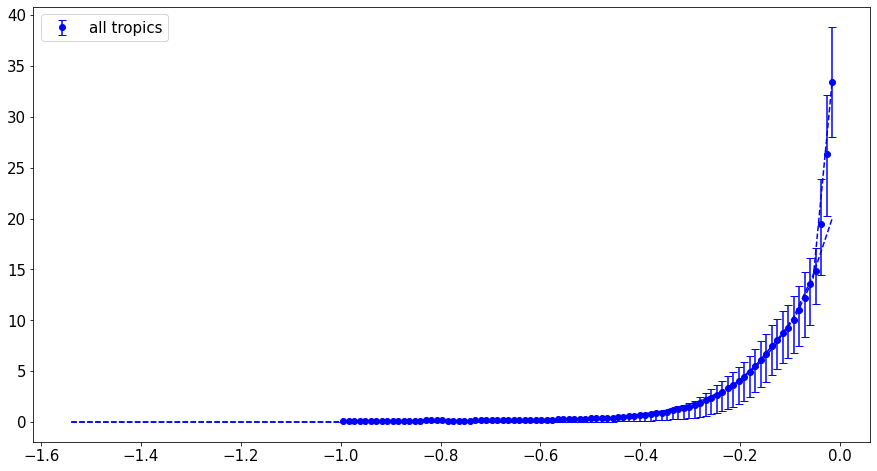

In [46]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
allBLs = np.array(BL_monthly_tropics).reshape(-1)
allprs = np.array(gpm_pr_monthly_tropics).reshape(-1)
idxs = (~np.isnan(allBLs)) & (~np.isnan(allprs))
allBLs=allBLs[idxs];allprs=allprs[idxs];

bins = np.linspace(-1.,0.1,101)
centers,means,_,q02,q98 = get_binned(allBLs,allprs,bins,itq=True)
ax.errorbar(centers,means,yerr=[(means-q02),(q98-means)],fmt='o',color='b',ecolor='b',capsize=4,label='all tropics')

x,y,rsq,BLPRALLTROPICS = fit(allBLs,allprs,model='exponential',return_func=True)
ax.plot(x,y,'--b')

SPLINE = interp1d(centers,means,kind='cubic',bounds_error=False,fill_value=0.)
ax.plot(x,SPLINE(x),'--b')

#a=9; b=0.4; BLPRFIT_PERSO = lambda x: np.exp(a*(x+b))
#ax.plot(x,BLPRFIT_PERSO(x),'--r')
  
ax.legend()
#ax.set_ylim(0,35)

## Line plots for the rest

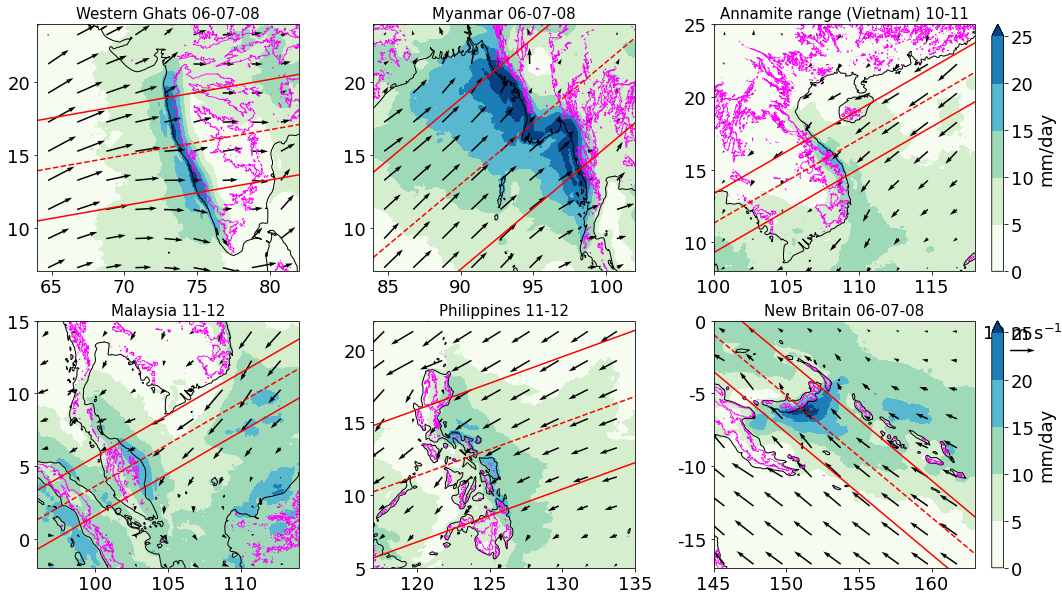

In [111]:
fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.2],height_ratios=[1,1],figure=fig)
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    ax.set_anchor('W')
    ax.coastlines()
    
    center=0.5; width=MR.width; clr='r'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    if i%3 !=2:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    else:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,cbar_kwargs={'label':'mm/day'})
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
     
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+MR._monthstr,fontsize=15)
    

    

# Quiver key (reference wind arrow)
qk = ax.quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


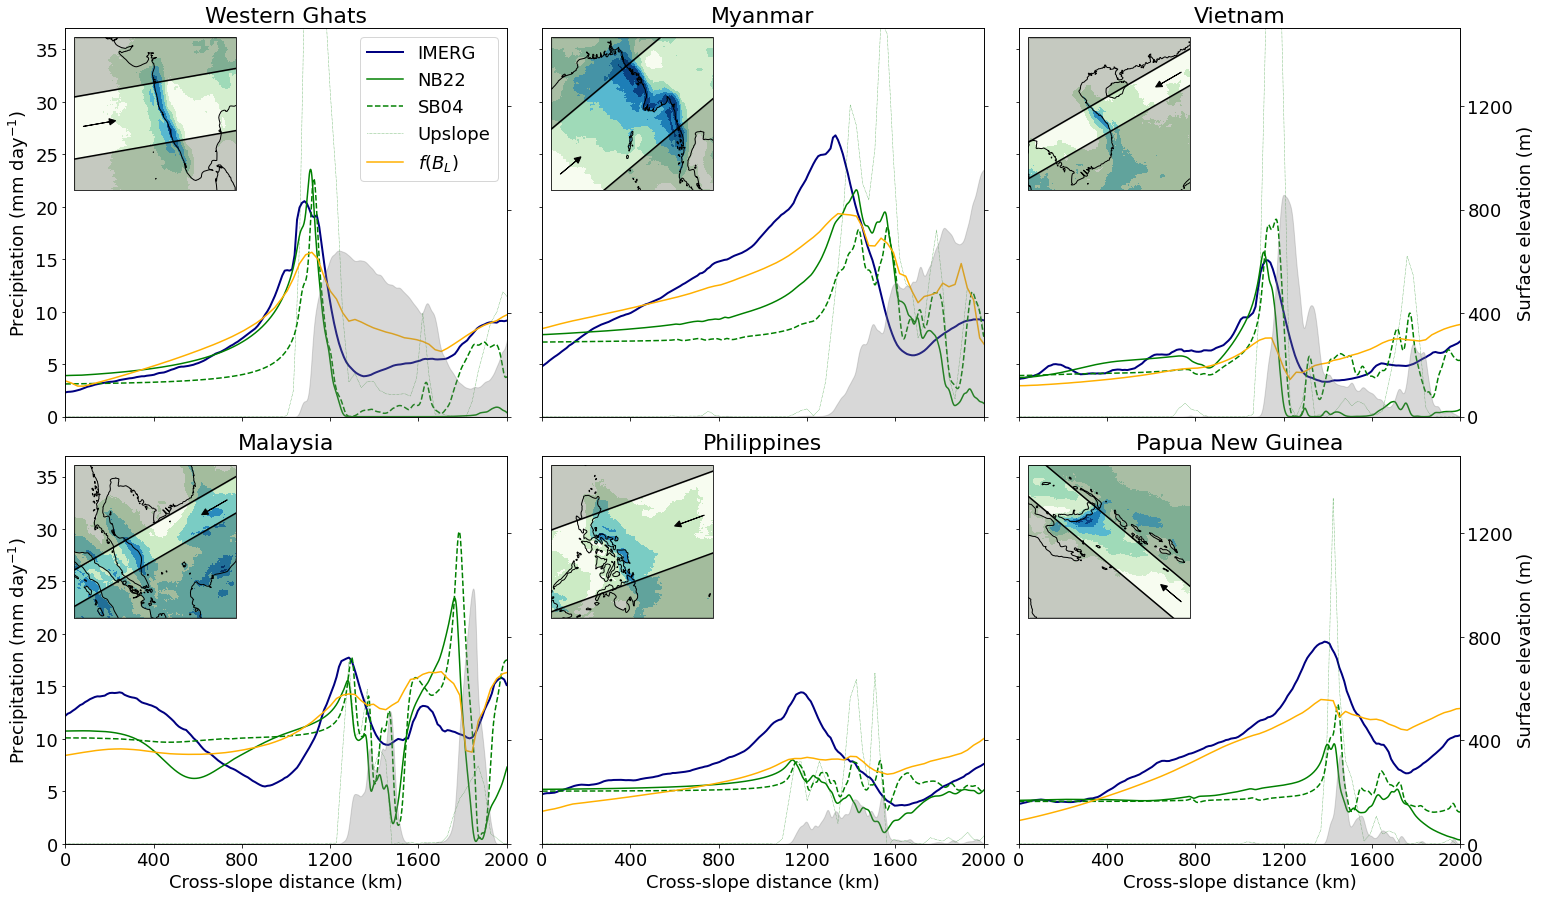

In [12]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(2,3,wspace=0.08,hspace=0.1)
axs = [fig.add_subplot(gs1[i,j]) for i in range(2) for j in range(3)]

# add them 1 by 1 ..
h=0.15;w=0.09
top_0 = 0.876; bot_0 = top_0-h; 
top_1 = 0.48; bot_1 = top_1-h; 
left_0 = 0.13; right_0 = left_0+w; 
left_1 = 0.395 ; right_1 = left_1+w;
left_2 = 0.66; right_2 = left_2+w;
gs00 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_0,right=right_0)
gs01 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_1,right=right_1)
gs02 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_2,right=right_2)
gs10 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_0,right=right_0)
gs11 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_1,right=right_1)
gs12 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_2,right=right_2)
insets = [fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree()) for gs in (gs00,gs01,gs02,gs10,gs11,gs12)]
for (ax,MR) in zip(insets,MRs):
    #sel_box(landmask,MR.box).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=[0,0.4],colors=('#97B7E1','#E6E6E6'),add_colorbar=False)
    MR.vars['GPM_PR'].plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    center=0.5; width=MR.width; clr='k'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    #ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.fill_between([x0,x1],[y0,y0],fx-(y1-y0)*width/np.cos(alpha),color=clr,alpha=0.2)
    ax.fill_between([x0,x1],fx+(y1-y0)*width/np.cos(alpha),[y1,y1],color=clr,alpha=0.2)
    
    if MR.angle<180:
        xa = x0+1
        eps=1
    else:
        xa = x1-1
        eps=-1
    norm=3
    dx = eps*norm/(1+alpha**2)
    dy = alpha*dx
    ax.arrow(xa, ym + alpha*(xa-xm),dx,dy,head_width=0.7,head_length=0.7,color='k')
    
    ax.coastlines()
    ax.set_title('')
    ax.set_xlabel('');ax.set_xticks([])
    ax.set_ylabel('');ax.set_yticks([])
    ax.set_xlim(MR.box[0],MR.box[1]);ax.set_ylim(MR.box[2],MR.box[3])

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    ### FIRST ###
    rot_slice(MR.vars['GPM_PR'],MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2,label='IMERG')
    filtr(rot_slice(MR.vars['LINEAR_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',label='NB22')
    filtr(rot_slice(MR.vars['SMITH_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',linestyle='--',label='SB04')
    rot_slice(MR.vars['UPSLOPE_PR'],MR.angle,MR.width).plot(ax=ax,color='green',linestyle=':',linewidth=0.5,label='Upslope')
    
    meanBL = MR.vars['BLSEMI_DAILY'].mean('time')
    rot_slice(BLPRFIT2(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='#FFB000',label=r'$f(B_L)$')
    #rot_slice(BLPRFIT_PERSO(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='r',linestyle='--')
        
    ax2 = ax.twinx()
    hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
    sigma=4.
    hrot_smooth = hrot**0*gaussian_filter(hrot,sigma)
    ax2.fill_between(hrot_smooth.x,0*hrot_smooth,hrot_smooth,color='grey',alpha=0.3)
    
    ax.set_ylim(0,37)
    ax.set_xlim(0,2000)
    ax.set_xticks(range(0,2001,400))
    
    ax2.set_ylim(0,1500)
    ax2.set_yticks(range(0,1201,400))
    ax.set_title(MR.Lname,fontsize=22)
    if i<3:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Cross-slope distance (km)")
    
    if i%3!=0:
        ax.set_yticklabels("")
    else:
        ax.set_ylabel(r"Precipitation (mm day$^{-1}$)")
        
    if i%3!=2:
        ax2.set_yticklabels("")
    else:
        ax2.set_ylabel(r"Surface elevation (m)")
        
axs[0].legend(loc=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

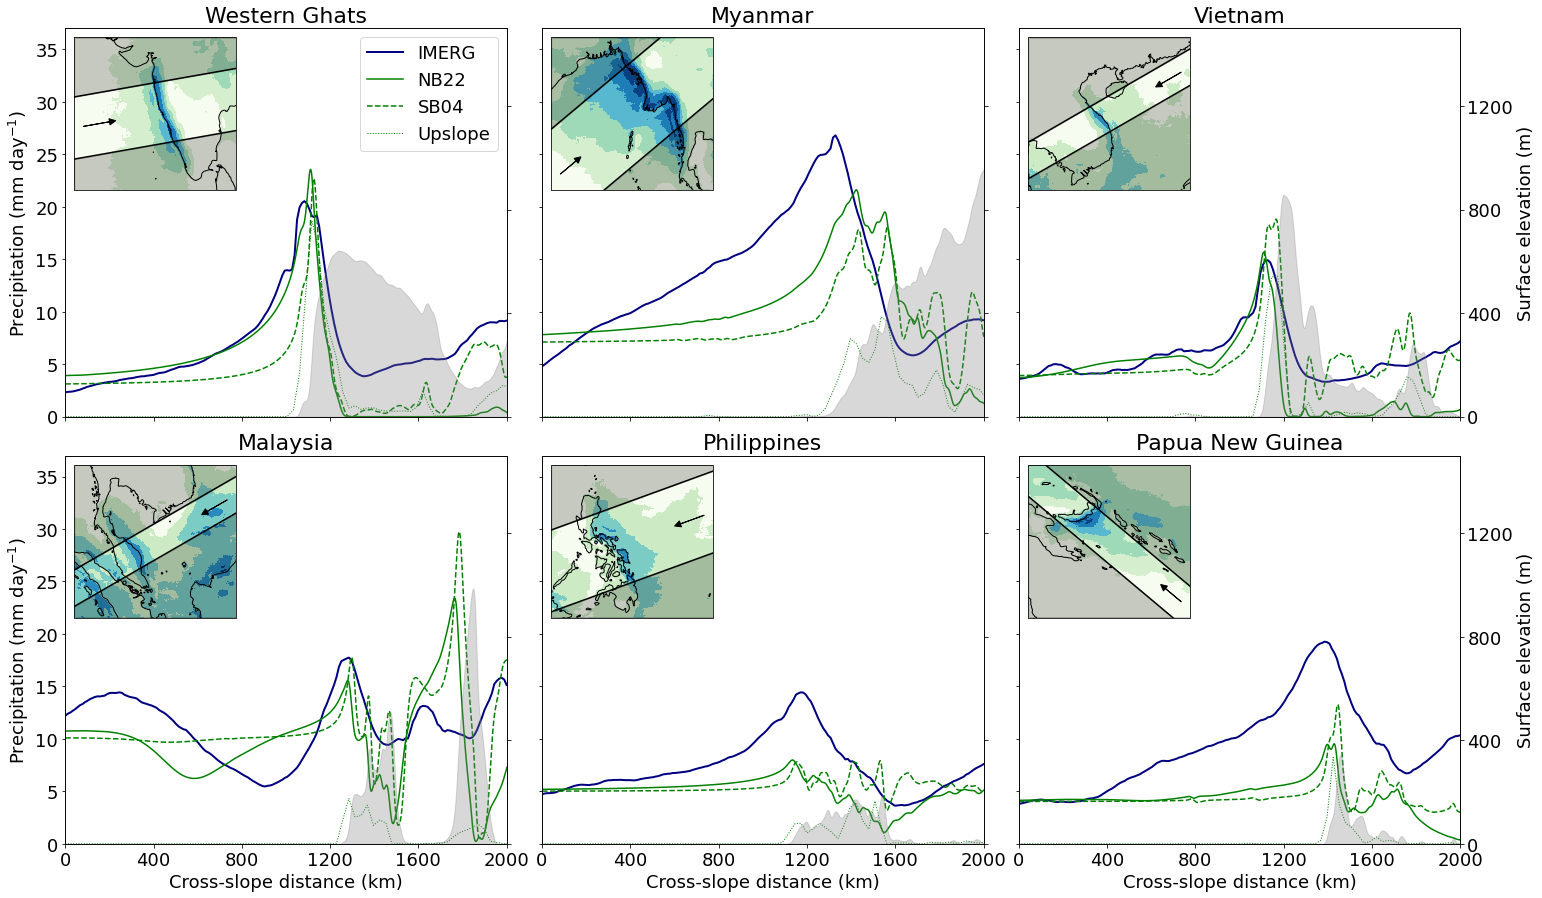

In [28]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(2,3,wspace=0.08,hspace=0.1)
axs = [fig.add_subplot(gs1[i,j]) for i in range(2) for j in range(3)]

# add them 1 by 1 ..
h=0.15;w=0.09
top_0 = 0.876; bot_0 = top_0-h; 
top_1 = 0.48; bot_1 = top_1-h; 
left_0 = 0.13; right_0 = left_0+w; 
left_1 = 0.395 ; right_1 = left_1+w;
left_2 = 0.66; right_2 = left_2+w;
gs00 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_0,right=right_0)
gs01 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_1,right=right_1)
gs02 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_2,right=right_2)
gs10 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_0,right=right_0)
gs11 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_1,right=right_1)
gs12 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_2,right=right_2)
insets = [fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree()) for gs in (gs00,gs01,gs02,gs10,gs11,gs12)]
for (ax,MR) in zip(insets,MRs):
    #sel_box(landmask,MR.box).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=[0,0.4],colors=('#97B7E1','#E6E6E6'),add_colorbar=False)
    MR.vars['GPM_PR'].plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    center=0.5; width=MR.width; clr='k'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    #ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.fill_between([x0,x1],[y0,y0],fx-(y1-y0)*width/np.cos(alpha),color=clr,alpha=0.2)
    ax.fill_between([x0,x1],fx+(y1-y0)*width/np.cos(alpha),[y1,y1],color=clr,alpha=0.2)
    
    if MR.angle<180:
        xa = x0+1
        eps=1
    else:
        xa = x1-1
        eps=-1
    norm=3
    dx = eps*norm/(1+alpha**2)
    dy = alpha*dx
    ax.arrow(xa, ym + alpha*(xa-xm),dx,dy,head_width=0.7,head_length=0.7,color='k')
    
    ax.coastlines()
    ax.set_title('')
    ax.set_xlabel('');ax.set_xticks([])
    ax.set_ylabel('');ax.set_yticks([])
    ax.set_xlim(MR.box[0],MR.box[1]);ax.set_ylim(MR.box[2],MR.box[3])

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    ### FIRST ###
    rot_slice(MR.vars['GPM_PR'],MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2,label='IMERG')
    filtr(rot_slice(MR.vars['LINEAR_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',label='NB22')
    filtr(rot_slice(MR.vars['SMITH_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',linestyle='--',label='SB04')
    rot_slice(0.25*MR.vars['UPSLOPE_PR'],MR.angle,MR.width).plot(ax=ax,color='green',linestyle=':',linewidth=1,label='Upslope')
    
    #meanBL = MR.vars['BLSEMI_DAILY'].mean('time')
    #rot_slice(BLPRFIT2(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='#FFB000',label=r'$f(B_L)$')
    #rot_slice(BLPRFIT_PERSO(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='r',linestyle='--')
        
    ax2 = ax.twinx()
    hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
    sigma=4.
    hrot_smooth = hrot**0*gaussian_filter(hrot,sigma)
    ax2.fill_between(hrot_smooth.x,0*hrot_smooth,hrot_smooth,color='grey',alpha=0.3)
    
    ax.set_ylim(0,37)
    ax.set_xlim(0,2000)
    ax.set_xticks(range(0,2001,400))
    
    ax2.set_ylim(0,1500)
    ax2.set_yticks(range(0,1201,400))
    ax.set_title(MR.Lname,fontsize=22)
    if i<3:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Cross-slope distance (km)")
    
    if i%3!=0:
        ax.set_yticklabels("")
    else:
        ax.set_ylabel(r"Precipitation (mm day$^{-1}$)")
        
    if i%3!=2:
        ax2.set_yticklabels("")
    else:
        ax2.set_ylabel(r"Surface elevation (m)")
        
axs[0].legend(loc=1)
fig.savefig('figs/prlines.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/prlines.png',dpi=70,bbox_inches='tight')


In [12]:
for MR in MRs:
    print(MR.name,np.sqrt(MR.U0**2+MR.V0**2))

ghats 10.04987562112089
myanmar 11.313708498984761
vietnam 8.602325267042627
malaysia 8.602325267042627
philippines 9.013878188659973
newbritain 9.300537618869138


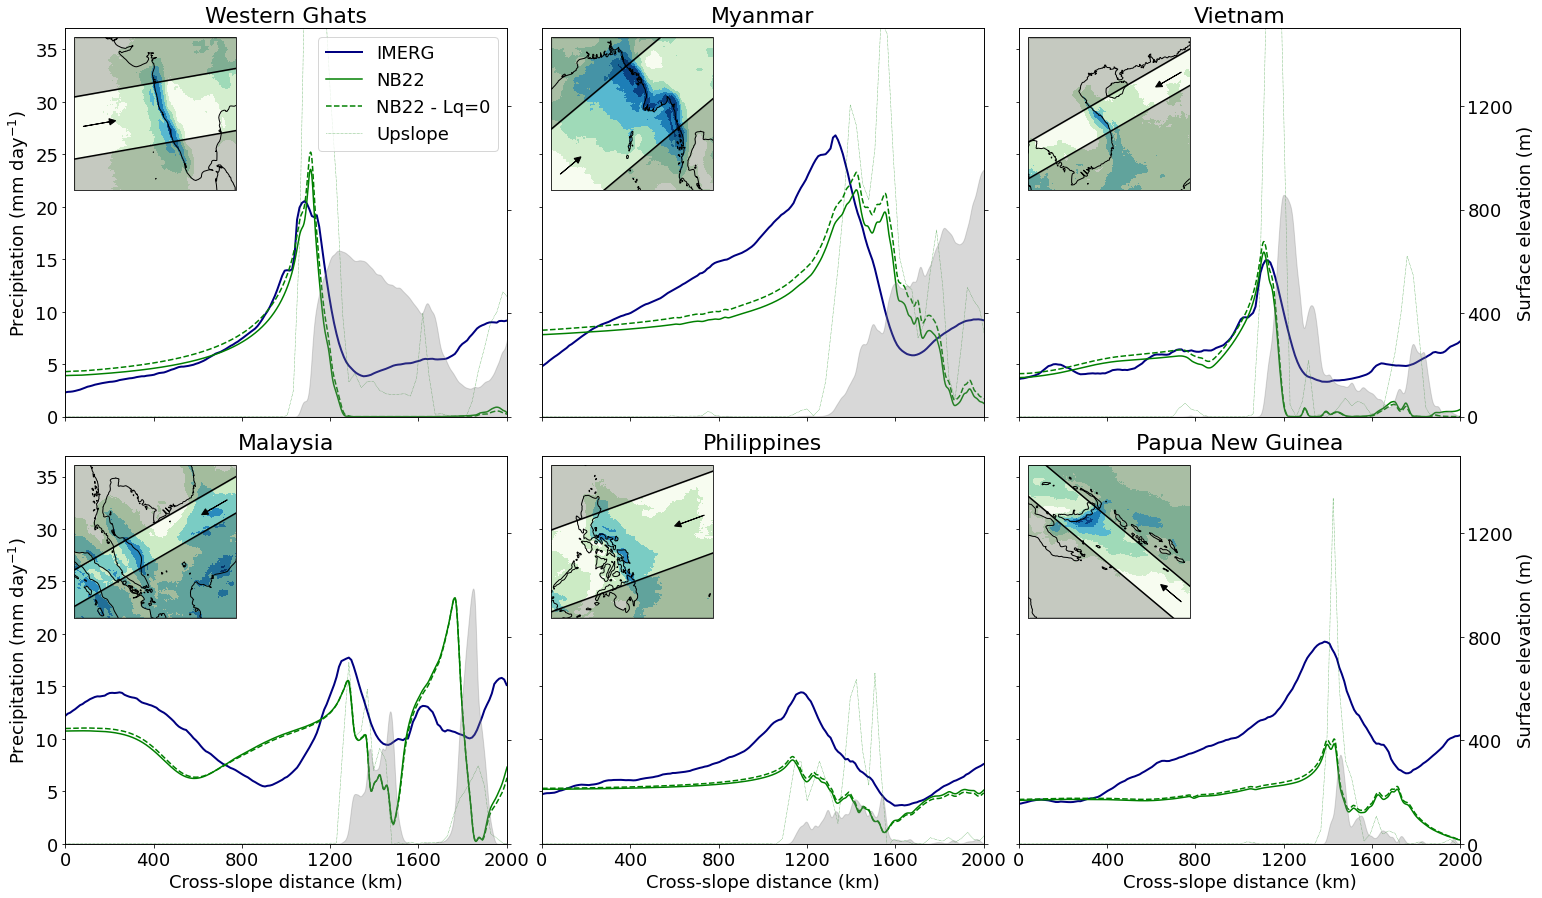

In [11]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(2,3,wspace=0.08,hspace=0.1)
axs = [fig.add_subplot(gs1[i,j]) for i in range(2) for j in range(3)]

# add them 1 by 1 ..
h=0.15;w=0.09
top_0 = 0.876; bot_0 = top_0-h; 
top_1 = 0.48; bot_1 = top_1-h; 
left_0 = 0.13; right_0 = left_0+w; 
left_1 = 0.395 ; right_1 = left_1+w;
left_2 = 0.66; right_2 = left_2+w;
gs00 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_0,right=right_0)
gs01 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_1,right=right_1)
gs02 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_2,right=right_2)
gs10 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_0,right=right_0)
gs11 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_1,right=right_1)
gs12 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_2,right=right_2)
insets = [fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree()) for gs in (gs00,gs01,gs02,gs10,gs11,gs12)]
for (ax,MR) in zip(insets,MRs):
    #sel_box(landmask,MR.box).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=[0,0.4],colors=('#97B7E1','#E6E6E6'),add_colorbar=False)
    MR.vars['GPM_PR'].plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    center=0.5; width=MR.width; clr='k'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    #ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.fill_between([x0,x1],[y0,y0],fx-(y1-y0)*width/np.cos(alpha),color=clr,alpha=0.2)
    ax.fill_between([x0,x1],fx+(y1-y0)*width/np.cos(alpha),[y1,y1],color=clr,alpha=0.2)
    
    if MR.angle<180:
        xa = x0+1
        eps=1
    else:
        xa = x1-1
        eps=-1
    norm=3
    dx = eps*norm/(1+alpha**2)
    dy = alpha*dx
    ax.arrow(xa, ym + alpha*(xa-xm),dx,dy,head_width=0.7,head_length=0.7,color='k')
    
    ax.coastlines()
    ax.set_title('')
    ax.set_xlabel('');ax.set_xticks([])
    ax.set_ylabel('');ax.set_yticks([])
    ax.set_xlim(MR.box[0],MR.box[1]);ax.set_ylim(MR.box[2],MR.box[3])

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    ### FIRST ###
    rot_slice(MR.vars['GPM_PR'],MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2,label='IMERG')
    filtr(rot_slice(MR.vars['LINEAR_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',label='NB22')
    filtr(rot_slice(MR.vars['LINEAR_PR_NOLQ'],MR.angle,MR.width)).plot(ax=ax,color='green',linestyle='--',label='NB22 - Lq=0')
    rot_slice(MR.vars['UPSLOPE_PR'],MR.angle,MR.width).plot(ax=ax,color='green',linestyle=':',linewidth=0.5,label='Upslope')
    
    #meanBL = MR.vars['BLSEMI_DAILY'].mean('time')
    #rot_slice(BLPRFIT2(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='#FFB000',label=r'$f(B_L)$')
    #rot_slice(BLPRFIT_PERSO(meanBL).fillna(0.),MR.angle,MR.width).plot(ax=ax,color='r',linestyle='--')
        
    ax2 = ax.twinx()
    hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
    sigma=4.
    hrot_smooth = hrot**0*gaussian_filter(hrot,sigma)
    ax2.fill_between(hrot_smooth.x,0*hrot_smooth,hrot_smooth,color='grey',alpha=0.3)
    
    ax.set_ylim(0,37)
    ax.set_xlim(0,2000)
    ax.set_xticks(range(0,2001,400))
    
    ax2.set_ylim(0,1500)
    ax2.set_yticks(range(0,1201,400))
    ax.set_title(MR.Lname,fontsize=22)
    if i<3:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Cross-slope distance (km)")
    
    if i%3!=0:
        ax.set_yticklabels("")
    else:
        ax.set_ylabel(r"Precipitation (mm day$^{-1}$)")
        
    if i%3!=2:
        ax2.set_yticklabels("")
    else:
        ax2.set_ylabel(r"Surface elevation (m)")
        
axs[0].legend(loc=1)

# Older stuff - Cascades

using dry stability, N=0.011 s^-1


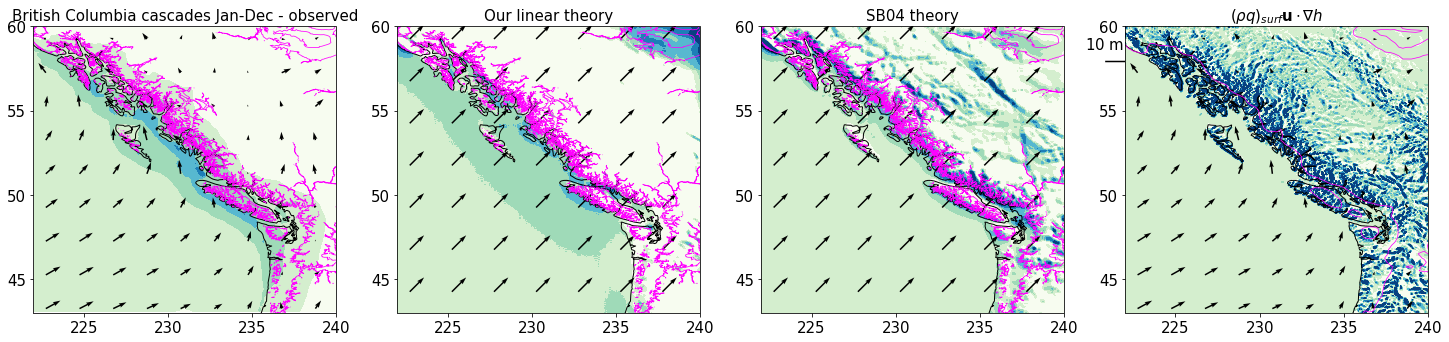

In [ ]:
monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axs = plt.subplots(1,4,figsize=(25,7),subplot_kw={'projection': ccrs.PlateCarree()})
MR=Cascades
    
### FIRST COLUMN ###
ax=axs[0]
box=MR.box
pr=MR.vars['GPM_PR']
pr[0,0]=26.
pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### SECOND COLUMN ###
ax=axs[1]
#p = p_lineartheory_region(MR,MR.U0,MR.V0,P0=MR.P0)
p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### THIRD COLUMN ###
ax=axs[2]
#p = p_smiththeory_region(MR,MR.U0,MR.V0,P0=MR.P0)
p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### FOURTH COLUMN ###
ax=axs[3]
m_per_degreelat = 6370*1e3*np.pi/180
zsfc = MR.vars['Z_HR'].coarsen(latitude=3,longitude=3,boundary='trim').mean()#*sel_box(landmask,MR.box)
p = 86400*1.2 * MR.vars['Q_SFC'].interp_like(zsfc) * (MR.vars['VAR_100U'].interp_like(zsfc)*zsfc.differentiate('longitude')/m_per_degreelat*2
                                   +MR.vars['VAR_100V'].interp_like(zsfc)*zsfc.differentiate('latitude')/m_per_degreelat)
p = np.maximum(p+MR.P0,0.).fillna(0.)
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### QUIVERS ###
u=MR.vars['VAR_100U']
v=MR.vars['VAR_100V']
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=len(u.latitude)//8
m=n
ibeg=3
iend=-1
for ax in axs[0],axs[3]:
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
n = int(n*1.25)
m=n    
for ax in axs[1:3]:
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
for ax in axs[:3]:
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
MR.vars['Z'].plot.contour(ax=axs[3],levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())

for ax in axs:
    ax.set_anchor('W')
    ax.coastlines()
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks([l-360 for l in lons])
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title(MR.Lname +' '+monthnames[MR.months[0]-1]+'-'+monthnames[MR.months[-1]-1]+' - observed',fontsize=15)
axs[1].set_title('Our linear theory',fontsize=15)
axs[2].set_title('SB04 theory',fontsize=15)
axs[3].set_title(r'$(\rho q)_{surf} \mathbf{u}\cdot\nabla h$',fontsize=15)

# Quiver key (reference wind arrow)
qk = axs[1].quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


using dry stability, N=0.011 s^-1


Text(0.5, 1.0, 'British Columbia cascades01-11-12')

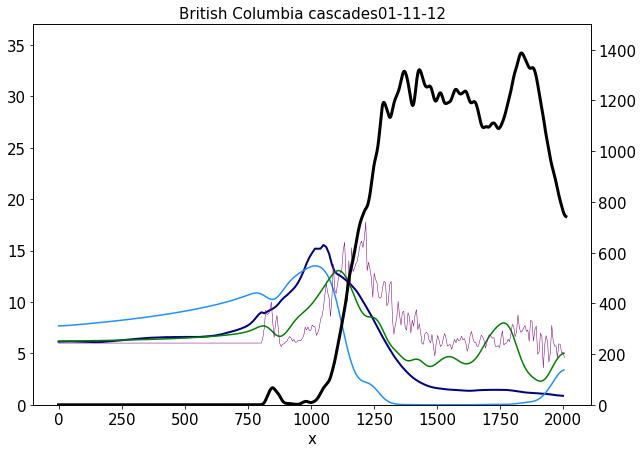

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
MR = Cascades
sigma=4
### FIRST ###
pr=MR.vars['GPM_PR']
rot_slice(pr,MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2)

### SECOND ###
p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
prot = rot_slice(p,MR.angle,MR.width)
(prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='dodgerblue')

### THIRD ###
p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
prot = rot_slice(p,MR.angle,MR.width)
(prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='g')

### FOURTH COLUMN ###
m_per_degreelat = 6370*1e3*np.pi/180
zsfc = MR.vars['Z_HR'].coarsen(latitude=3,longitude=3,boundary='trim').mean()#*sel_box(landmask,MR.box)
p = 86400*1.2 * MR.vars['Q_SFC'].interp_like(zsfc) * (MR.vars['VAR_100U'].interp_like(zsfc)*zsfc.differentiate('longitude')/m_per_degreelat*2
                                   +MR.vars['VAR_100V'].interp_like(zsfc)*zsfc.differentiate('latitude')/m_per_degreelat)
p = np.maximum(p+MR.P0,0.).fillna(0.)
rot_slice(p,MR.angle,MR.width).plot(ax=ax,color='purple',linewidth=0.5)


ax2 = ax.twinx()
hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
(hrot**0*gaussian_filter(hrot,sigma)).plot(ax=ax2,color='k',linewidth=3)
    
ax.set_ylim(0,37)
ax2.set_ylim(0,1500)
ax.set_title(MR.Lname + MR._monthstr,fontsize=15)